#4. MOVIES. FIRST ANALYSIS

##4.01 Initial work.

As in previous notebook, we firstly import some basic libraries, get access to folders in our own Google Drive account and import json files from my Google Drive account:

In [0]:
#Importing basic libraries:
import pandas as pd
import numpy as np
import timeit
import ujson
import os

In [2]:
#Click on the link, copy the authorization code and paste it on the box.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Now we have access to our own Google Drive account:
!ls -lh "/content/drive/My Drive/"

total 3.2G
drwx------ 2 root root 4.0K Jul 14 07:08  20180714_Deep_Learning
-rw------- 1 root root  76K Oct 22 18:13  6885.json
drwx------ 2 root root 4.0K Jun 26  2016 'avast! Files (XT1068, UWbYzWPVmAmwlrlD)'
-rw------- 1 root root 2.7M Oct 28 21:03  Cast_Crew_ids.csv
drwx------ 2 root root 4.0K Jul 18 18:38 'Colab Notebooks'
-rw------- 1 root root  44K Feb  4  2018  contacts.vcf
-rw------- 1 root root    1 Apr  9  2018  facturaIVA.gsheet
-rw------- 1 root root  50K Nov  9 13:01  genres.xlsx
-rw------- 1 root root 1.5M Oct 24 17:34  IMDB_5000_movie.csv
-rw------- 1 root root  12K Nov  3 10:33  InflationConverter.xlsx
-rw------- 1 root root    1 Nov 10 10:21 'Mis cuentas.gsheet'
-rw------- 1 root root 117K Oct 28 21:04  Movies_ids.csv
-rw------- 1 root root 2.2M Nov 16 17:17  MoviesUS.csv
-rw------- 1 root root 1.5G Oct 12 15:09  movies.zip
-rw------- 1 root root    1 Nov 17 16:27 'Nuestras Cuentas.gsheet'
-rw------- 1 root root 1.8G Oct 27 13:06  people.zip
-rw------- 1 root root 6.4

In [0]:
# Install the PyDrive wrapper & import libraries. This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client. This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Getting movies.zip:
file_id = '1-jrX_p1VfgMceGIj7SK_eIef8syIGsdL'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("movies.zip")

In [5]:
!ls -lh

total 1.5G
-rw-r--r-- 1 root root 2.5K Nov 18 09:03 adc.json
drwx------ 3 root root 4.0K Nov 18 09:04 drive
-rw-r--r-- 1 root root 1.5M Nov 18 10:29 IMDB_5000_movie.csv
-rw-r--r-- 1 root root 1.5G Nov 18 09:07 movies.zip
drwxr-xr-x 2 root root 4.0K Nov 15 19:33 sample_data
drwxr-xr-x 3 root root 4.0K Nov 18 09:07 themoviedb_data


In [10]:
#We will get an error message. No worries about it!
!mkdir themoviedb_data
!cd themoviedb_data && unzip -q ../movies.zip
!ls -hl themoviedb_data

warning [../movies.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [../movies.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #409792).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)
total 12M
drwxr-xr-x 2 root root 12M Nov 18 09:08 movies


In [6]:
#And so we have our 409,791 files:
!ls -1 themoviedb_data/movies | wc -l

409791


Now we import the json files to dfMovies dataframe:

In [0]:
def moviesIterator(path):
    intI = 0
    for root, dirs, files in os.walk(path):
        for f in files:
            intI += 1
            if f.endswith('.json'):
                fp = os.path.join(root,f)
                with open(fp) as o:
                    data = ujson.load(o)
                
                if intI % 10000 == 0:
                    #Just to control how it goes:
                    print(intI)
                    
                result = {"titles": data["alternative_titles"]["titles"], 
                       "budget": data["budget"], "credits_cast": data["credits"]["cast"], "credits_crew": data["credits"]["crew"],
                       "genres": data["genres"], "movie_id": data["id"], "imdb_id": data["imdb_id"],
                       "keywords": data["keywords"]["keywords"], "original_language": data["original_language"],
                       "original_title": data["original_title"], "overview": data["overview"],
                       "popularity": data["popularity"], 
                       "production_companies": data["production_companies"], "production_countries": data["production_countries"],
                       "release_date": data["release_date"], "release_dates": data["release_dates"]["results"],
                       "revenue": data["revenue"], 
                       "reviews_page": data["reviews"]["page"],
                       "reviews_results": data["reviews"]["results"],
                       "reviews_total_pages": data["reviews"]["total_pages"],
                       "reviews_total_results": data["reviews"]["total_results"],
                       "runtime": data["runtime"],
                       "spoken_languages": data["spoken_languages"], "status": data["status"],
                       "tagline": data["tagline"], "title": data["title"], 
                       "vote_average": data["vote_average"], "vote_count": data["vote_count"]}
                    
                #We check in dfTypeCheck that "belongs_to_collection" is sometimes null. This is why we need to deal with it separately:
                if data["belongs_to_collection"] is None:
                    result["belongs_to_collection_id"] = None
                    result["belongs_to_collection_name"] = None
                else:
                    result["belongs_to_collection_id"] = data["belongs_to_collection"]["id"]
                    result["belongs_to_collection_name"] = data["belongs_to_collection"]["name"]
                    
                #We tale only non adult films:
                if data["adult"] == False:
                    yield result

In [8]:
path = "./themoviedb_data/movies"
dfMovies = pd.DataFrame()
tic=timeit.default_timer()
dfMovies = pd.DataFrame(moviesIterator(path))
toc=timeit.default_timer()
print((toc - tic)/60, ' min') #elapsed time in minutes

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000


298.2773628949981

In [9]:
dfMovies.columns

Index(['belongs_to_collection_id', 'belongs_to_collection_name', 'budget',
       'credits_cast', 'credits_crew', 'genres', 'imdb_id', 'keywords',
       'movie_id', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'release_dates', 'revenue', 'reviews_page',
       'reviews_results', 'reviews_total_pages', 'reviews_total_results',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'titles',
       'vote_average', 'vote_count'],
      dtype='object')

In [10]:
dfMovies.shape

(393239, 30)

We will deal later with the "lists of dictionaries" columns using the functions we created in last notebook:

In [0]:
def columnIteratorMovies(columnName, *args):
    for id in dfMovies.index:
        for dict in dfMovies[dfMovies.index == id][columnName].iloc[0]:
            outputDict = {'movie_id': id}
            for key in args:
                outputDict[key] = dict.get(key,None)
            yield outputDict

def columnProcessesMovies (columnName, *args):
    #I need to declare dfMovies as global as I will change it inside this function.
    global dfMovies
    
    dfOutput = pd.DataFrame()
    dfOutput = pd.DataFrame(columnIteratorMovies(columnName, *args))
    
    #Sanity check:
    dfCheck = pd.DataFrame(dfMovies[columnName].map(len).value_counts())
    dfCheck['calculation']=dfCheck[columnName]*dfCheck.index
    
    if dfOutput.shape[0] == dfCheck['calculation'].sum():
        dfMovies = dfMovies.drop(columnName, axis=1)
        return dfOutput
    else:
        return "Error in process"

def columnIteratorReleaseDates(*args):
    dfMoviesReleaseDates1 = columnProcessesMovies ('release_dates', 'iso_3166_1', 'release_dates')
    
    for id in dfMoviesReleaseDates1.index:
        for dict in dfMoviesReleaseDates1[dfMoviesReleaseDates1.index == id]['release_dates'].iloc[0]:
            outputDict = {'movie_id': dfMoviesReleaseDates1[dfMoviesReleaseDates1.index == id]['movie_id'].iloc[0],
                         'iso_3166_1': dfMoviesReleaseDates1[dfMoviesReleaseDates1.index == id]['iso_3166_1'].iloc[0]}
            for key in args:
                outputDict[key] = dict.get(key,None)
            yield outputDict            

##4.02 Initial research.

Let's have a look to our target variable: **`revenue`**.

In [12]:
dfMovies['revenue'].dtype

dtype('int64')

In [13]:
dfMovies['revenue'].isnull().sum()

0

In [14]:
dfMovies[dfMovies['revenue']==0].shape[0]

383224

In [15]:
dfMovies[dfMovies['revenue']==0].shape[0]/dfMovies.shape[0]

0.974532027596449

So although **`revenue`** has no null values, it is 0 in 97% of rows! We clearly can assume that 0 means null. This issue will significantly limit our study!

Besides, let's have a look to the lowest values of **`revenue`**:

In [16]:
dfMovies['revenue'].value_counts().sort_index().head(10)

-12         1
 0     383224
 1         66
 2         33
 3         21
 4         12
 5         15
 6         14
 7         10
 8         17
Name: revenue, dtype: int64

We have a negative value and some low values that are hard to believe they are true. We will take some actions here later.

Let's make a similar analysis for **`budget`**:

In [17]:
dfMovies['budget'].dtype

dtype('int64')

In [18]:
dfMovies['budget'].isnull().sum()

0

In [19]:
dfMovies[dfMovies['budget']==0].shape[0]

374718

In [20]:
dfMovies[dfMovies['budget']==0].shape[0]/dfMovies.shape[0]

0.9529014161871024

In [21]:
dfMovies['budget'].value_counts().sort_index().head(10)

0    374718
1       194
2        78
3        59
4        26
5        85
6        33
7        21
8        23
9        12
Name: budget, dtype: int64

As we see, we have a similar situation with **`budget`**. We will bring informtion from a different database, [IMDb](https://www.imdb.com/), for two different reasons:
1. It will be a good quality check for our TMDB data.
2. It can be useful to increase the amount of movies for what we know their revenue.

##4.03 Importing IMDb data and merging with dfMovies.

Revenue information from IMDb was not so easy to get. After some search, we got [IMDb 5000 movie dataset](https://toolbox.google.com/datasetsearch/search?query=movies&docid=zDmMCvkxFert5jadAAAAAA%3D%3D). The good point here is that we have the IMDb movies identifier in our **`dfMovies`** dataframe from TMDB, so the merge will be possible.

We have this file from IMDb availabe in my Google Drive account:

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_id = '1ebj6EkGylXTGldfGfJO_AHEAncNf4zKA'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("IMDB_5000_movie.csv")

In [22]:
!ls -lh

total 1.5G
-rw-r--r-- 1 root root 2.5K Nov 18 09:03 adc.json
drwx------ 3 root root 4.0K Nov 18 09:04 drive
-rw-r--r-- 1 root root 1.5M Nov 18 10:29 IMDB_5000_movie.csv
-rw-r--r-- 1 root root 1.5G Nov 18 09:07 movies.zip
drwxr-xr-x 2 root root 4.0K Nov 15 19:33 sample_data
drwxr-xr-x 3 root root 4.0K Nov 18 09:07 themoviedb_data


In [23]:
!head IMDB_5000_movie.csv 

color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
Color,James Cameron,723,178,0,855,Joel David Moore,1000,760505847,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar ,886204,4834,Wes Studi,0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,3054,English,USA,PG-13,237000000,2009,936,7.9,1.78,33000
Color,Gore Verbinski,302,169,563,1000,Orlando Bloom,40000,309404152,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End ,471220,48350,Jack Davenport,0,goddess|marriage ceremony|marriage proposal|pirate|singapore,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,

In [24]:
my_file_path='./IMDB_5000_movie.csv'

#Reading file and saving in df
dfMovies5000 = pd.read_csv(my_file_path)
dfMovies5000.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [25]:
#It is always good to check the tail to look for updating mistakes:
dfMovies5000.tail()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
5038,Color,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,...,6.0,English,Canada,NaN,NaN,2013.0,470.0,7.7,NaN,84
5039,Color,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,...,359.0,English,USA,TV-14,NaN,NaN,593.0,7.5,16.00,32000
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,...,3.0,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16
5041,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,...,9.0,English,USA,PG-13,NaN,2012.0,719.0,6.3,2.35,660
5042,Color,Jon Gunn,43.0,90.0,16.0,16.0,Brian Herzlinger,86.0,85222.0,Documentary,...,84.0,English,USA,PG,1100.0,2004.0,23.0,6.6,1.85,456


In [26]:
dfMovies5000.shape

(5043, 28)

In [27]:
dfMovies5000.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

IMDb id is not clear showed. But it is included inside the string of **`movie_imdb_link`**:

In [28]:
dfMovies5000['movie_imdb_link'].sample(5)

509     http://www.imdb.com/title/tt0110357/?ref_=fn_t...
337     http://www.imdb.com/title/tt0380510/?ref_=fn_t...
411     http://www.imdb.com/title/tt0496806/?ref_=fn_t...
2625    http://www.imdb.com/title/tt0110367/?ref_=fn_t...
4134    http://www.imdb.com/title/tt1754264/?ref_=fn_t...
Name: movie_imdb_link, dtype: object

In [29]:
dfMovies5000[['movie_imdb_link', 'gross', 'budget']].dtypes

movie_imdb_link     object
gross              float64
budget             float64
dtype: object

In [30]:
#Let's check null values:
dfMovies5000[['movie_imdb_link', 'gross', 'budget']].isnull().any()

movie_imdb_link    False
gross               True
budget              True
dtype: bool

So **`movie_imdb_link`** has no nulls. Good. Let's try to extract the IMDb indentifier from it, and this should be our primary key.

In [31]:
dfMovies5000['movie_imdb_link'].sample(5)

49      http://www.imdb.com/title/tt1351685/?ref_=fn_t...
1240    http://www.imdb.com/title/tt0363988/?ref_=fn_t...
2058    http://www.imdb.com/title/tt1798709/?ref_=fn_t...
582     http://www.imdb.com/title/tt0298148/?ref_=fn_t...
245     http://www.imdb.com/title/tt1291150/?ref_=fn_t...
Name: movie_imdb_link, dtype: object

In [32]:
#We can extract IMDb identifier with this instruction:
dfMovies5000['movie_imdb_link'].sample(5).str.split("/").map(lambda list: list[4])

2628    tt0265298
1763    tt0309698
4119    tt0118327
3696    tt2226417
3189    tt1226236
Name: movie_imdb_link, dtype: object

Let's create a new column in dfMovies5000 with IMDb identifier. We will need to check that it can be our primary key.

In [0]:
dfMovies5000['imdb_id'] = dfMovies5000['movie_imdb_link'].str.split("/").map(lambda list: list[4])

In [34]:
dfMovies5000.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'imdb_id'],
      dtype='object')

In [35]:
#Let's confirm that our new identifier has always the same length with no blanks:
dfMovies5000['imdb_id'].str.strip().map(len).value_counts()

9    5043
Name: imdb_id, dtype: int64

In [36]:
#Do we have duplicates? Yes, we have :(
dfMovies5000['imdb_id'].duplicated().sum()

124

In [37]:
#Let's have a look to one of them:
dfMovies5000['imdb_id'][dfMovies5000['imdb_id'].duplicated()].head()

137    tt0918940
187    tt1673434
204    tt4262980
303    tt3332064
389    tt1502712
Name: imdb_id, dtype: object

In [38]:
dfMovies5000[dfMovies5000['imdb_id'] == 'tt0918940']

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,imdb_id
63,Color,David Yates,248.0,110.0,282.0,103.0,Alexander Skarsgård,11000.0,124051759.0,Action|Adventure|Drama|Romance,...,English,USA,PG-13,180000000.0,2016.0,10000.0,6.6,2.35,29000,tt0918940
137,Color,David Yates,248.0,110.0,282.0,103.0,Alexander Skarsgård,11000.0,124051759.0,Action|Adventure|Drama|Romance,...,English,USA,PG-13,180000000.0,2016.0,10000.0,6.6,2.35,29000,tt0918940


It seems it is exactly the same row. Are our 124 duplicates on imdb_id duplicates for the whole row? No, they are not:

In [39]:
dfMovies5000.duplicated().sum()

45

But we are really interested on **`imdb_id`**, **`gross`** and **`budget`**. Are those duplicates on imdb_id duplicates for these three columns?

In [40]:
dfMovies5000[['imdb_id', 'gross', 'budget']].duplicated().sum()

123

Almost! We will simplify the problem and for that only duplicate we will take only the first of the rows:

In [0]:
dfMovies5000 = dfMovies5000.drop_duplicates(subset='imdb_id', keep='first')

In [42]:
dfMovies5000.shape

(4919, 29)

Now we can merge **`dfMovies`** and **`dfMovies5000`**. Before merging, let's check how many not null values we have for **`gross`** and **`budget`**:

In [43]:
dfMovies5000[['movie_imdb_link', 'gross', 'budget']].count()

movie_imdb_link    4919
gross              4056
budget             4434
dtype: int64

And do we have 0 values?

In [44]:
print(dfMovies5000[dfMovies5000['gross']==0].shape[0])
print(dfMovies5000[dfMovies5000['budget']==0].shape[0])

0
0


We don´t have 0 values. So criteria is different than it is in **`dfMovies`**.

What are the lowest values of these columns?

In [45]:
print(dfMovies5000['gross'].min())
print(dfMovies5000['budget'].min())

162.0
218.0


This is more reliable than the lowest values we saw in **`dfMovies`**! We will come to this issue later.

Let´s have a quick view to IMDb data before merging:

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
sns.set()

Distribution throughout the years:

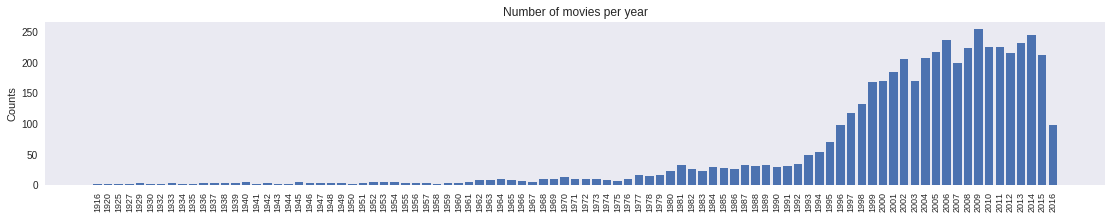

In [47]:
X = dfMovies5000['title_year'].value_counts().sort_index().index.map(lambda number: '%.0f'%number)
Y = dfMovies5000['title_year'].value_counts().sort_index().values

figure, axes = plt.subplots(1,1)

plt.bar(range(len(X)), Y)
plt.xticks(range(len(X)), X, rotation=90, size=9)
plt.grid(False)

plt.title('Number of movies per year')
plt.xlabel('')
plt.ylabel('Counts')

figure.set_size_inches([19,3])

plt.show()

Distribution per production countries:

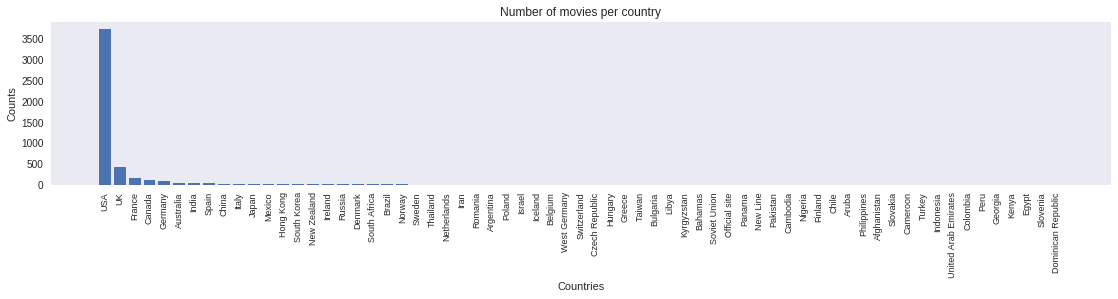

In [48]:
X = dfMovies5000['country'].value_counts().sort_values(ascending=False).index
Y = dfMovies5000['country'].value_counts().sort_values(ascending=False).values

figure, axes = plt.subplots(1,1)

plt.bar(range(len(X)), Y)
plt.xticks(range(len(X)), X, rotation=90, size=9)
plt.grid(False)

plt.title('Number of movies per country')
plt.xlabel('Countries')
plt.ylabel('Counts')

figure.set_size_inches([19,3])

plt.show()

We will find similar distributions of years and countries in **`dfMovies`**: high proportion of movies in last 20 years and mainly US productions.

Now let´s merge **`dfMovies`** and **`dfMovies5000`**:

There are some null values in **`imdb_id`** from **`dfMovies`**:

In [49]:
#We can not do much about it!
dfMovies[['movie_id', 'imdb_id']].count()

movie_id    393239
imdb_id     337380
dtype: int64

In [50]:
dfMovies[['movie_id', 'imdb_id']].isnull().sum()

movie_id        0
imdb_id     55859
dtype: int64

Besides, we have empty strings and one duplicate (tt1564005):

In [51]:
dfMovies['imdb_id'].value_counts()[0:5]

             45838
tt1564005        2
tt0059838        1
tt0493408        1
tt1186219        1
Name: imdb_id, dtype: int64

In [0]:
#Let´s clean up those '' to null values:
dfMovies['imdb_id']=dfMovies['imdb_id'].map(lambda x: None if x=='' else x)

In [53]:
#Done!
dfMovies['imdb_id'].value_counts()[0:5]

tt1564005    2
tt0443858    1
tt2082222    1
tt0133456    1
tt5424984    1
Name: imdb_id, dtype: int64

In [54]:
dfMovies['imdb_id'].isnull().sum()

101697

In [55]:
#Let's have a look to the duplicate. It seems to be the same movie, but we can not be sure. As it is only one row, we leave it as it is.
dfMovies[dfMovies['imdb_id']=='tt1564005']

,belongs_to_collection_id,belongs_to_collection_name,budget,credits_cast,credits_crew,genres,imdb_id,keywords,movie_id,original_language,...,reviews_total_pages,reviews_total_results,runtime,spoken_languages,status,tagline,title,titles,vote_average,vote_count
188175,NaN,None,0,"[{'cast_id': 0, 'character': 'Joss Jenner', 'c...",[],"[{'id': 9648, 'name': 'Mystery'}, {'id': 10770...",tt1564005,[],545015,en,...,0,0,88.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Lies Between Friends,[],5.0,1
235256,NaN,None,0,"[{'cast_id': 1004, 'character': 'Joss Jenner',...","[{'credit_id': '52fe49efc3a36847f81ae499', 'de...","[{'id': 18, 'name': 'Drama'}]",tt1564005,[],101318,en,...,0,0,88.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Lies Between Friends,"[{'iso_3166_1': 'ES', 'title': 'Asesinato entr...",4.8,4


How many merges do we have?

In [56]:
dfMovies.merge(dfMovies5000, how='inner', on='imdb_id').shape

(4798, 58)

Good, most of them!

In [57]:
dfMovies5000.shape[0]

4919

Let's rename the columns in **`dfMovies5000`** we are interested in and then we merge **`dfMovies`** and **`dfMovies5000`**. We will only take from **`dfMovies5000`** columns gross and budget. Information about facebook likes or ratings could be interesting, but we can not measure how this is affected by the revenue itself. This would be different if we had that information specifically when the movie was released. Besides, we would have a bias for films 20 years ago, when social networks were not so popular.

In [0]:
dfMovies5000 = dfMovies5000.rename(columns={'gross': 'imdb_revenue', 'budget': 'imdb_budget'})

In [0]:
dfMovies = dfMovies.merge(dfMovies5000[['imdb_id', 'imdb_revenue', 'imdb_budget']], how='left', on='imdb_id')

In [60]:
dfMovies.columns

Index(['belongs_to_collection_id', 'belongs_to_collection_name', 'budget',
       'credits_cast', 'credits_crew', 'genres', 'imdb_id', 'keywords',
       'movie_id', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'release_dates', 'revenue', 'reviews_page',
       'reviews_results', 'reviews_total_pages', 'reviews_total_results',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'titles',
       'vote_average', 'vote_count', 'imdb_revenue', 'imdb_budget'],
      dtype='object')

In [61]:
dfMovies.shape

(393239, 32)

##4.04 Reducing our universe.

###Improving revenue and budget information.

Our goal is to crate new columns with revenue and budget information from TMDB and IMDB information.

Firstly, we change 0 to null values in columns **`budget`** and **`revenue`** in **`dfMovies`**:

In [62]:
#Counting null values:
dfMovies[['revenue', 'budget', 'imdb_revenue', 'imdb_budget']].isnull().sum()

revenue              0
budget               0
imdb_revenue    389188
imdb_budget     388825
dtype: int64

In [63]:
#Counting 0's:
dfMovies[['revenue', 'budget', 'imdb_revenue', 'imdb_budget']].applymap(lambda x: x==0).sum()

revenue         383224
budget          374718
imdb_revenue         0
imdb_budget          0
dtype: int64

In [0]:
dfMovies['revenue'] = dfMovies['revenue'].map(lambda num: None if num != num or num is None or num==0 else num)
dfMovies['budget'] = dfMovies['budget'].map(lambda num: None if num != num or num is None or num==0 else num)

Let's check it worked:

In [65]:
#Counting null values:
dfMovies[['revenue', 'budget', 'imdb_revenue', 'imdb_budget']].isnull().sum()

revenue         383224
budget          374718
imdb_revenue    389188
imdb_budget     388825
dtype: int64

In [66]:
#Counting 0's:
dfMovies[['revenue', 'budget', 'imdb_revenue', 'imdb_budget']].applymap(lambda x: x==0).sum()

revenue         0
budget          0
imdb_revenue    0
imdb_budget     0
dtype: int64

We will define two new columns, **`revenue_final`** and **`budget_final`** which will take the value from TMDB, unless it is null and then they will take the value from IMDB:

In [0]:
dfMovies['revenue_final'] = dfMovies['revenue'].combine_first(dfMovies['imdb_revenue'])
dfMovies['budget_final'] = dfMovies['budget'].combine_first(dfMovies['imdb_budget'])

But we saw many very low values for TMDB source in revenue and budget. They could be errors. We will take IMDB values when TMDB values are not greater than $50:

In [0]:
dfMovies.loc[(dfMovies['revenue']<=50) & (dfMovies['imdb_revenue'].notnull()), 'revenue_final'] = dfMovies.loc[(dfMovies['revenue']<=50) & (dfMovies['imdb_revenue'].notnull()), 'imdb_revenue']
dfMovies.loc[(dfMovies['budget']<=50) & (dfMovies['imdb_budget'].notnull()), 'budget_final'] = dfMovies.loc[(dfMovies['budget']<=50) & (dfMovies['imdb_budget'].notnull()), 'imdb_budget']

In [69]:
#Let's check it worked:
dfMovies[(dfMovies['revenue']<=50) & (dfMovies['imdb_revenue'].notnull())][['revenue', 'imdb_revenue', 'revenue_final']].head()

,revenue,imdb_revenue,revenue_final
44852,15.0,13350177.0,13350177.0
67466,10.0,10149779.0,10149779.0
136710,12.0,12189514.0,12189514.0
155760,7.0,7680.0,7680.0
221370,26.0,26876529.0,26876529.0


In [70]:
#Let's count:
dfMovies[['budget', 'revenue', 'imdb_budget', 'imdb_revenue', 'budget_final', 'revenue_final']].count()

budget           18521
revenue          10015
imdb_budget       4414
imdb_revenue      4051
budget_final     19201
revenue_final    10857
dtype: int64

In [71]:
#And we still have a row with a negative revenue! We will exclude it later.
dfMovies[['budget', 'revenue', 'imdb_budget', 'imdb_revenue', 'budget_final', 'revenue_final']].applymap(lambda num: num<0).sum()

budget           0
revenue          1
imdb_budget      0
imdb_revenue     0
budget_final     0
revenue_final    1
dtype: int64

**We will create our model only from movies where **`revenue_final`** is greater than 0.**

###Status

**We will only use in our model released movies.**

In [72]:
dfMovies['status'].value_counts()

Released           387266
Post Production      2161
In Production        1262
Rumored              1230
Planned              1203
Canceled              117
Name: status, dtype: int64

###First universe reduction:

So, in order to simplify the script, we will apply the first reduction of our universe of movies:

In [73]:
#First we check volumes:
dfMovies[(dfMovies['revenue_final']>0) & (dfMovies['status']=='Released')].shape

(10825, 34)

In [0]:
dfMovies = dfMovies[(dfMovies['revenue_final']>0) & (dfMovies['status']=='Released')]

In [75]:
#Let's have a look to the result:
dfMovies.groupby('status')[['budget', 'revenue', 'imdb_budget', 'imdb_revenue', 'budget_final', 'revenue_final']].count()

,budget,revenue,imdb_budget,imdb_revenue,budget_final,revenue_final
status,,,,,,
Released,7149,9985,3995,4048,7624,10825


Now that we have reduced our universe, let´s deal with some "list of dictionaries" columns that we will need: **`production_countries`** and **`release_dates`**.

In [76]:
#Firstly we need movies ids to be the index of dfMovies.
dfMovies.index = dfMovies['movie_id']

tic=timeit.default_timer()

dfMoviesProductionCountries = columnProcessesMovies ('production_countries', 'iso_3166_1', 'name')
print("dfMoviesProductionCountries generated")
dfMoviesReleaseDates = pd.DataFrame(columnIteratorReleaseDates('certification', 'iso_639_1', 'release_date', 'type'))
print("dfMoviesReleaseDates generated")

toc=timeit.default_timer()
print((toc - tic)/60, ' min') #elapsed time in minutes

dfMoviesProductionCountries generated
dfMoviesReleaseDates generated
2.817717029883291  min


###Release Date

How do our movies distribute throughout the years?

In [77]:
dfMovies[['release_date']].dtypes

release_date    object
dtype: object

We need to convert release_date into a date format:

In [78]:
#We do not have nulls:
dfMovies[['release_date']].isnull().sum()

release_date    0
dtype: int64

In [79]:
#But we have empty strings:
dfMovies[dfMovies['release_date'].str.len()==0].shape[0]

136

In [0]:
#So firstly we remove blanks:
dfMovies['release_date'] = dfMovies['release_date'].str.strip()

In [81]:
#What format does this column have?
dfMovies['release_date'].str.len().value_counts()

10    10689
0       136
Name: release_date, dtype: int64

In [82]:
dfMovies['release_date'].head()

movie_id
13523     2008-10-16
139293    2012-10-16
9792      2006-03-10
50838     2011-04-01
10191     2010-03-05
Name: release_date, dtype: object

In [83]:
#Let's make sure that there is no mistakes with the format: YYYY-MM-DD or YYYY-DD-MM:
#This is the month:
dfMovies['release_date'].map(lambda date: date[5:7]).unique()

array(['10', '03', '04', '01', '08', '12', '06', '07', '11', '09', '05',
       '02', ''], dtype=object)

In [84]:
#This is the day:
dfMovies['release_date'].map(lambda date: date[8:10]).unique()

array(['16', '10', '01', '05', '25', '19', '07', '08', '22', '09', '02',
       '18', '27', '23', '20', '12', '06', '30', '28', '15', '04', '26',
       '24', '03', '11', '13', '29', '14', '21', '17', '31', ''],
      dtype=object)

In [0]:
#So we can convert release_date into datetime format:
dfMovies['release_date']= dfMovies['release_date'].map(pd.to_datetime)

In [86]:
#This converted our '' into None's.
dfMovies['release_date'].isnull().sum()

136

Let's have a look to the distribution of the movies that we will use in our model (*status = released and revenue_final > 0*) throughout the years:

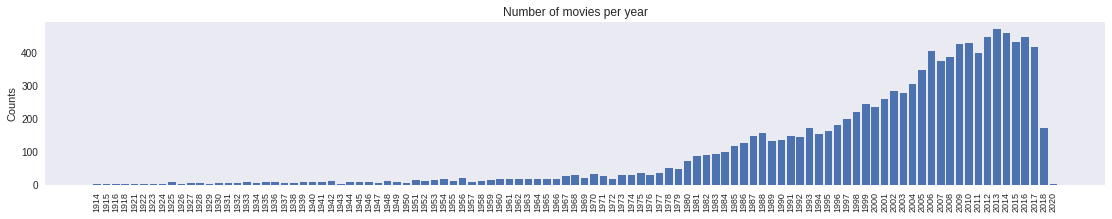

In [87]:
X = dfMovies['release_date'].map(lambda datetime: datetime.year).value_counts().sort_index().index.map(lambda number: '%.0f'%number)
Y = dfMovies['release_date'].map(lambda datetime: datetime.year).value_counts().sort_index().values

figure, axes = plt.subplots(1,1)

plt.bar(range(len(X)), Y)
plt.xticks(range(len(X)), X, rotation=90, size=9)
plt.grid(False)

plt.title('Number of movies per year')
plt.ylabel('Counts')
figure.set_size_inches([19,3])

plt.show()

Revenue data for movies released on 2018 could not be closed yet. And for sure there can not be any movies released on 2020!. So **we will exclude movies released after 2017**.

###Production countries and releases per country. Second universe reduction.

Let's have a look to the distribution of production countries for our movies:

(Pay attention: the graph below counts every tuple "movie-production country")

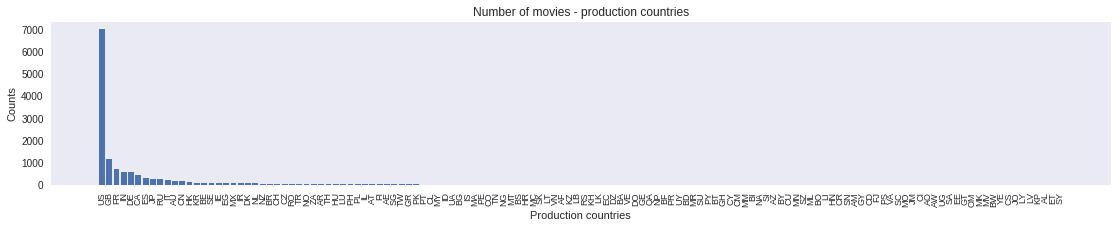

In [88]:
X = dfMoviesProductionCountries['iso_3166_1'].value_counts().index
Y = dfMoviesProductionCountries['iso_3166_1'].value_counts().values

figure, axes = plt.subplots(1,1)

plt.bar(range(len(X)), Y)
plt.xticks(range(len(X)), X, rotation=90, size=9)
plt.grid(False)

plt.title('Number of movies - production countries')
plt.xlabel('Production countries')
plt.ylabel('Counts')
figure.set_size_inches([19,3])

plt.show()

As we see, our data don´t fairly represent movies universe worldwide, as we mainly have US productions.

In [89]:
dfMoviesProductionCountries['iso_3166_1'].value_counts().head(7)

US    6986
GB    1173
FR     731
IN     566
DE     559
CA     436
ES     319
Name: iso_3166_1, dtype: int64

Let´s have a look now at the volumes of releases by country:

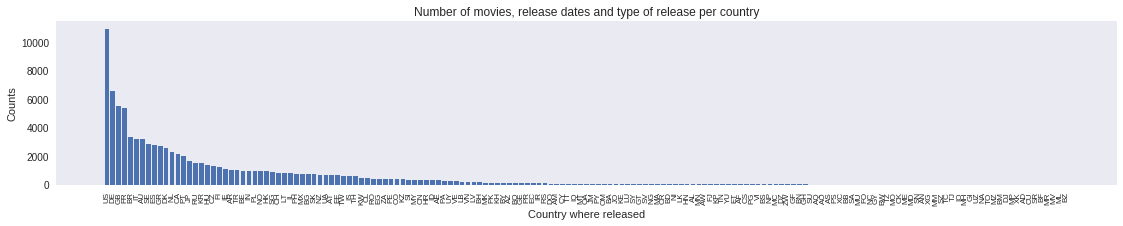

In [90]:
X = dfMoviesReleaseDates['iso_3166_1'].value_counts().index
Y = dfMoviesReleaseDates['iso_3166_1'].value_counts().values

figure, axes = plt.subplots(1,1)

plt.bar(range(len(X)), Y)
plt.xticks(range(len(X)), X, rotation=90, size=8)
plt.grid(False)

plt.title('Number of movies, release dates and type of release per country')
plt.xlabel('Country where released')
plt.ylabel('Counts')

figure.set_size_inches([19,3])

plt.show()

In [91]:
dfMoviesReleaseDates['iso_3166_1'].value_counts().head(7)

US    10918
DE     6597
GB     5539
FR     5352
BR     3320
IT     3237
AU     3218
Name: iso_3166_1, dtype: int64

As expected, US leads the ranking again. Although volumes in other countries are very significant. This is because US productions are released all over the world.

So, in order to deploy a fair analysis, **we will concentrate in all movies released in the US before 2018**. 

Then we will have to filer using column **`release_date`** in **`dfMoviesReleaseDates`**, where we can get the information about the release dates **on the US**. Again we will have to make sure that **`release_date`** has a date format:

In [92]:
#What format does this column have?
dfMoviesReleaseDates['release_date'].str.len().value_counts()

24    91688
Name: release_date, dtype: int64

In [93]:
dfMoviesReleaseDates['release_date'].head()

0    2009-08-14T00:00:00.000Z
1    2008-11-13T00:00:00.000Z
2    2009-07-31T00:00:00.000Z
3    2008-10-17T00:00:00.000Z
4    2008-10-16T00:00:00.000Z
Name: release_date, dtype: object

In [94]:
#Let's make sure that there is no mistakes with the format: YYYY-MM-DD or YYYY-DD-MM:
#This is the month:
dfMoviesReleaseDates['release_date'].map(lambda date: date[5:7]).unique()

array(['08', '11', '07', '10', '03', '01', '09', '04', '06', '12', '05',
       '02'], dtype=object)

In [95]:
#This is the day:
dfMoviesReleaseDates['release_date'].map(lambda date: date[8:10]).unique()

array(['14', '13', '31', '17', '16', '26', '09', '07', '01', '20', '22',
       '10', '06', '21', '29', '18', '15', '04', '05', '02', '03', '24',
       '25', '12', '27', '08', '11', '19', '30', '28', '23'], dtype=object)

In [0]:
#So we can convert release_date into datetime format:
dfMoviesReleaseDates['release_date'] = dfMoviesReleaseDates['release_date'].map(lambda str: str[0:10]).map(pd.to_datetime)

In [97]:
dfMoviesReleaseDates[['release_date']].dtypes

release_date    datetime64[ns]
dtype: object

Let´s create now a dataframe with movies id's  from **movies released in the US before 2018**, which we will use to restrict our universe again:

In [0]:
dfMoviesIdsUS = pd.DataFrame(dfMoviesReleaseDates[(dfMoviesReleaseDates['release_date']<='2017-12-31') & (dfMoviesReleaseDates['iso_3166_1']=='US')]['movie_id'].unique(), columns=['movie_id'])

In [99]:
dfMoviesIdsUS.shape[0]

8790

In [101]:
dfMovies = dfMovies.merge(dfMoviesIdsUS, how='inner')
dfMovies.shape

(8790, 32)

Now we will export the list of our movies id's to a csv file. We will use it in other notebooks to filter the movies for our model and so keep more free memory.

In [102]:
dfMoviesIdsUS.head()

,movie_id
0,13523
1,9792
2,50838
3,10191
4,14435


In [0]:
dfMoviesIdsUS.to_csv('Movies_ids.csv')

In [105]:
!ls -lh

total 1.5G
-rw-r--r-- 1 root root 2.5K Nov 18 09:03 adc.json
drwx------ 3 root root 4.0K Nov 18 09:04 drive
-rw-r--r-- 1 root root 1.5M Nov 18 10:29 IMDB_5000_movie.csv
-rw-r--r-- 1 root root  93K Nov 18 16:37 Movies_ids.csv
-rw-r--r-- 1 root root 1.5G Nov 18 09:07 movies.zip
drwxr-xr-x 2 root root 4.0K Nov 15 19:33 sample_data
drwxr-xr-x 3 root root 4.0K Nov 18 09:07 themoviedb_data


In [0]:
!cp Movies_ids.csv /content/drive/"My Drive"

###Selecting my people universe.

Now we will select all people id's (credits cast and crew) in our movies universe. This will allow us to reduce the number of people json files to import and so keep more free memory.

Firstly we need to deel with columns **`credits_cast`** and **`credits_crew`** in **`dfMovies`**:

In [107]:
#Firstly we need movies ids to be the index of dfMovies.
dfMovies.index = dfMovies['movie_id']

tic=timeit.default_timer()

dfMoviesCast = columnProcessesMovies ('credits_cast', 'cast_id', 'character', 'gender', 'id', 'name', 'order')
print("dfMoviesCast generated")
dfMoviesCrew = columnProcessesMovies ('credits_crew', 'department', 'gender', 'id', 'job', 'name')
print("dfMoviesCrew generated")

toc=timeit.default_timer()
print((toc - tic)/60, ' min') #elapsed time in minutes

dfMoviesCast generated
dfMoviesCrew generated
0.24208155545002227  min


In [109]:
#How many people id's do we have?
pd.DataFrame(pd.concat([dfMoviesCast['id'],dfMoviesCrew['id']]).unique(), columns=["id"]).shape[0]

182317

In [0]:
#Let's generate a csv file with it:
pd.DataFrame(pd.concat([dfMoviesCast['id'],dfMoviesCrew['id']]).unique(), columns=["id"]).to_csv('Cast_Crew_ids.csv')

In [111]:
!ls -lh

total 1.5G
-rw-r--r-- 1 root root 2.5K Nov 18 09:03 adc.json
-rw-r--r-- 1 root root 2.4M Nov 18 16:44 Cast_Crew_ids.csv
drwx------ 3 root root 4.0K Nov 18 09:04 drive
-rw-r--r-- 1 root root 1.5M Nov 18 10:29 IMDB_5000_movie.csv
-rw-r--r-- 1 root root  93K Nov 18 16:37 Movies_ids.csv
-rw-r--r-- 1 root root 1.5G Nov 18 09:07 movies.zip
drwxr-xr-x 2 root root 4.0K Nov 15 19:33 sample_data
drwxr-xr-x 3 root root 4.0K Nov 18 09:07 themoviedb_data


In [0]:
!cp Cast_Crew_ids.csv /content/drive/"My Drive"